# Mnist_Batch_Normalization
Btach norm을 사용하는 모델과 사용하지 않는 모델 비교
- Gradient vanishing 이나 exploding 해결
- 학습 속도 가속

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train = True,
                          transform = transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                          train = False,
                          transform = transforms.ToTensor(),
                          download=True)

In [4]:
# parameters
learning_rate = 0.01
batch_size = 32
training_epochs = 10

In [5]:
# data_loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size = batch_size,
                                          shuffle=True,
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [6]:
# nn layers
linear1 = nn.Linear(784,32,bias = True)
linear2 = nn.Linear(32,32,bias = True)
linear3 = nn.Linear(32,10,bias = True)
relu = nn.ReLU() 
bn1 = nn.BatchNorm1d(32)
bn2 = nn.BatchNorm1d(32)

# Batch norm을 사용하지 않는 모델
nn_linear1 = nn.Linear(784,32,bias=True)
nn_linear2 = nn.Linear(32,32,bias=True)
nn_linear3 = nn.Linear(32,10,bias=True)

In [7]:
# activation 이전에 batch norm
bn_model = nn.Sequential(linear1,bn1,relu,
                         linear2,bn2,relu,
                         linear3).to(device)
nn_model = nn.Sequential(linear1,relu,
                         linear2,relu,
                         linear3).to(device)

In [8]:
# cost /loss optimizer
criterion = nn.CrossEntropyLoss().to(device)
bn_optimizer = torch.optim.Adam(bn_model.parameters(),lr= learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(),lr= learning_rate)

In [12]:
# losses와 Accuracy를 기록하여 그래프화 한다
train_losses = []
train_accs = []

valid_losses = []
valid_accs  =[]
train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()

    for X,Y in train_loader:
        X = X.view(-1,28*28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_hypo = bn_model(X)
        bn_loss = criterion(bn_hypo,Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_hypo = nn_model(X)
        nn_loss = criterion(nn_hypo,Y)
        nn_loss.backward()
        nn_optimizer.step()
    
    with torch.no_grad():
        bn_model.eval()

        # Test the model using train set
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i,(X,Y) in enumerate(train_loader):
            X = X.view(-1,28*28).to(device)
            Y = Y.to(device)

            # bn_model acc 및 loss
            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            # nn_model acc 및 loss
            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss = bn_loss / train_total_batch
        bn_acc = bn_acc / train_total_batch
        nn_loss = nn_loss / train_total_batch
        nn_acc = nn_acc / train_total_batch

        # save train losses/acc
        train_losses.append([bn_loss,nn_loss])
        train_accs.append([bn_acc,nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))

        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            # bn_model acc 및 loss
            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            # nn_model acc 및 loss
            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss = bn_loss / test_total_batch
        bn_acc = bn_acc / test_total_batch
        nn_loss = nn_loss / test_total_batch
        nn_acc = nn_acc / test_total_batch

            # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
print('\nLearning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.05618(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.20208(nn_acc:0.96)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.09994(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.33779(nn_acc:0.95)
[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.05639(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.20905(nn_acc:0.96)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.09786(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.41779(nn_acc:0.95)
[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.04740(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.20373(nn_acc:0.95)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.08657(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.30765(nn_acc:0.94)
[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.05078(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.20539(nn_acc:0.95)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.09047(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.34283(nn_acc:0.94)
[Epoch 5-TRAIN] Batchnor

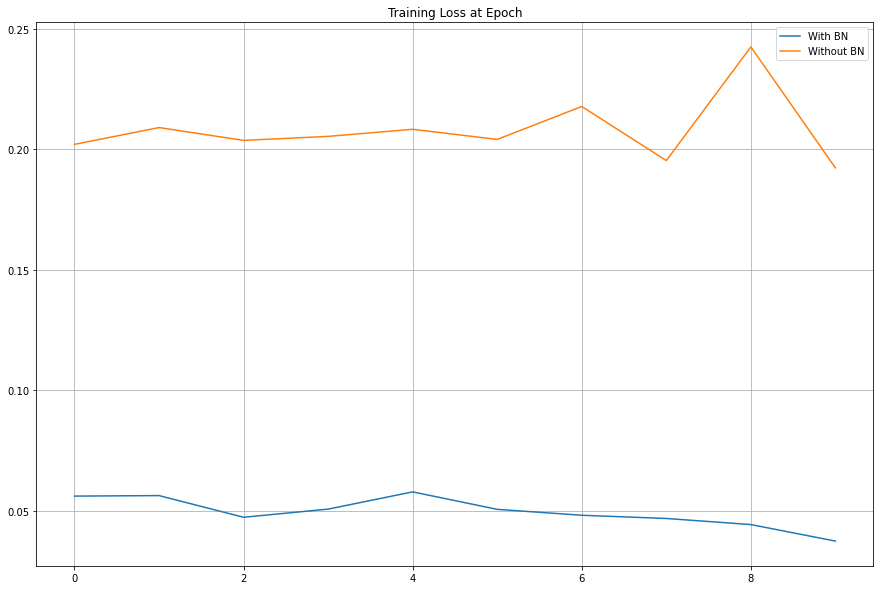

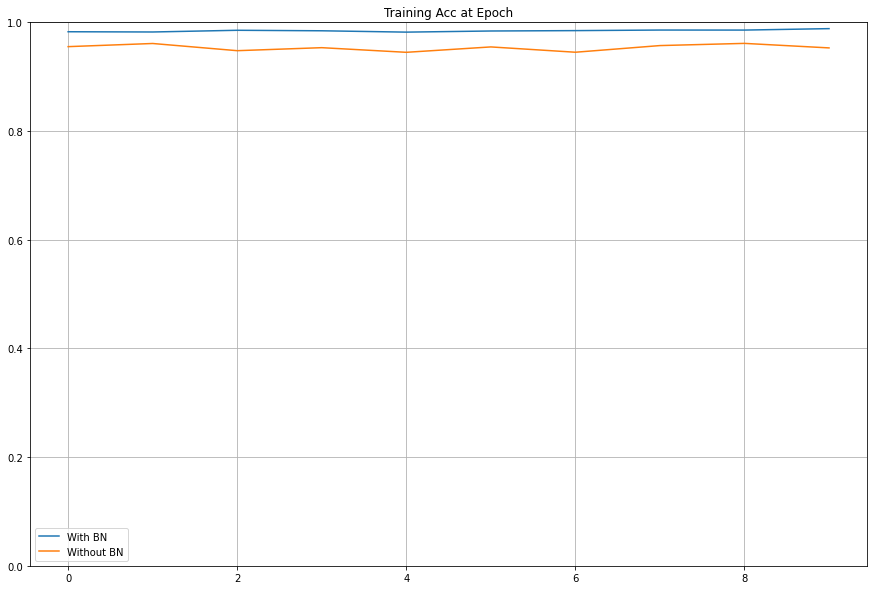

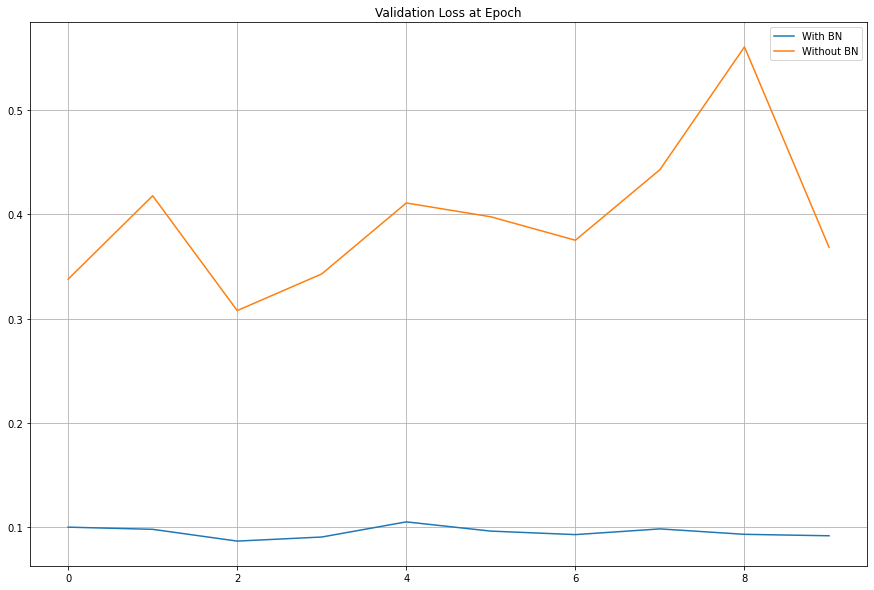

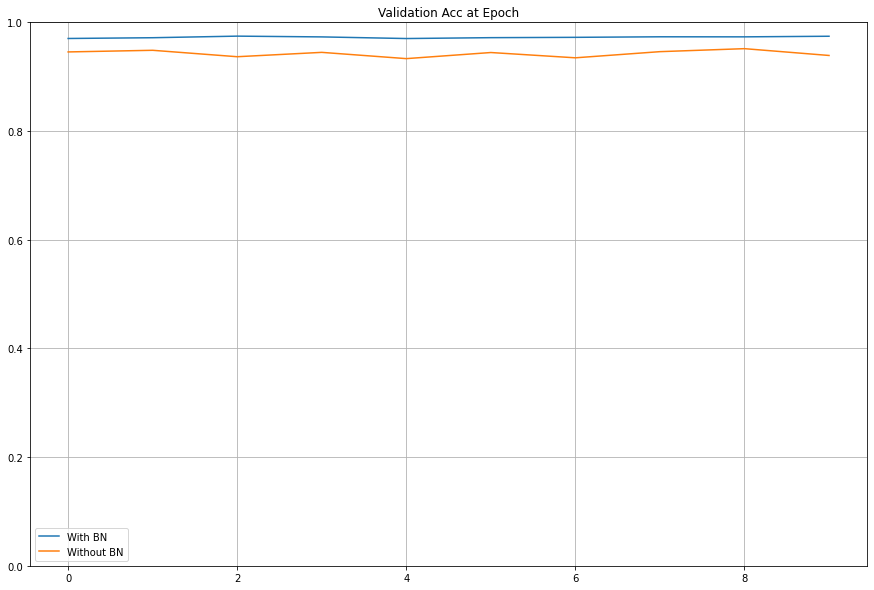

In [13]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')